In [1]:
import os
import ee
import datetime
import tqdm
import json

import pandas as pd
import geopandas as gp
import numpy as np
import rsfuncs as rs

import scipy.interpolate as interp
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
ee.Initialize()

In [2]:
# Read files, make polygons
kc = pd.read_csv('../data/fmp_kc_faunt.csv')
gdf = gp.read_file("../shape/cv.shp")
data = rs.load_data()

# Split cv into polygons
area = rs.gdf_to_ee_poly(gdf.simplify(0.01))
polys = rs.gen_polys(area, dx = 0.2, dy = 0.2)
polydict = polys.getInfo()

strstart = '2001-01-01'
strend = '2019-12-31'

startdate = datetime.datetime.strptime(strstart, "%Y-%m-%d")
enddate = datetime.datetime.strptime(strend, "%Y-%m-%d")
years = range(2001, 2020)

In [3]:
# Ensure each poly is a single geometry 

valid_polys = []

for i in tqdm(polydict['features'][:]):
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
    pols = aoi.getInfo()['coordinates']
    if len(pols) == 0:
        continue
    if len(pols) == 1:
        valid_polys.append(ee.Geometry.Polygon(pols))
    if len(pols) > 1:
        for i in pols:
#             print(i)
            valid_polys.append(ee.Geometry.Polygon(i))


In [5]:
annual_irr = {}

for y in tqdm(years[:1]):
    
    # print year and nlcd col 
    print(y)
    
    yearstart = "{}-01-01".format(str(y))
    yearend = "{}-12-31".format(str(y))

    # Select the nlcd dataset
    dataset =  data['nlcd']
    ic = dataset[0]
    var = dataset[1]
    res = dataset[3]

    # find the nearest nlcd dataset
    col = ic.filterDate(ee.Date(yearstart).advance(-1, 'years'), ee.Date(yearstart).advance(2, 'years')).first()
    if not col.getInfo():
        col = ic.filterDate(ee.Date(yearstart).advance(-3, 'years'), ee.Date(yearstart).advance(2, 'years')).first()

    
    # Print the nearest NLCD col
    print(col.getInfo()['properties']['system:index'])
    
    # Build the out dict 
    annual_stats = { k:0 for k,v in rs.nlcd_nums2classes().items()}
    
    # Loop through polys 
    for poly in tqdm(valid_polys[:]):

        # Select poly as geom
        aoi = poly
        
        # Get the count of pixel vals for each landcover class. 
        t = col.reduceRegion(ee.Reducer.frequencyHistogram(), aoi, res).get(var)

        freqs = t.getInfo()
        
        # Add it to the out dict 
        for k,v in freqs.items():
             annual_stats[int(k)]+=v 

    # Compile teh annual stats. Lctypes 81 and 82 are crop and pasture 
    notcrop = [annual_stats[x] for x in annual_stats.keys() if x not in [81,82]]
    crop = [annual_stats[x] for x in annual_stats.keys() if x in [81,82]]

    pctirr = np.array(crop).sum() / np.array(list(annual_stats.values())).sum()
    pctnonirr = np.array(notcrop).sum() / np.array(list(annual_stats.values())).sum()
    
    print("IRRIGATED pct = {} ".format(str(pctirr)))
    
    annual_irr[y] = pctirr
        

2001
NLCD2001



IRRIGATED pct = 0.6147950665018246 



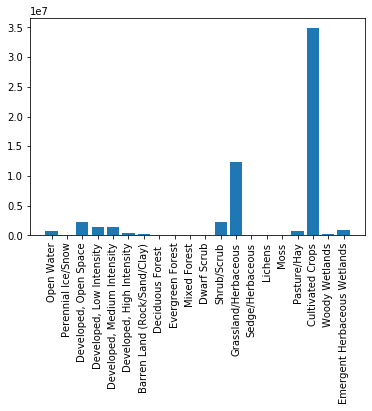

In [6]:
plt.bar([rs.nlcd_nums2classes()[int(k)] for k,v in annual_stats.items()],annual_stats.values())
plt.xticks(rotation=90)
plt.show()